# NEU Surface Defect Tutorial
In this notebook, we'll explore the NEU Surface Defect dataset. This dataset includes a total of 1800 grayscale images sized 200x200. The images feature 6 unique defect classes (300 images per defect). These defects are crazing (Cr), inclusions (In), patches (Pa), pitted surfaces (PS), rolled-in scale (RS), and scratches (Sc). 

We'll explore a few methods that might be useful in MSE applications. Many of us use image data of some kind; I hope this will be just the beginning of what you come up with!

In [63]:
from pathlib import Path
from natsort import natsorted
import pandas as pd
import sys
sys.path.append('../src/') # set path to ../src/ to find helper functions
from utils import get_files
from preprocessing import process_image
import os

import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
## Organize the Project
First things first, we have to get all of our data accessible.

In [43]:
# set the data and image directories
DATA_DIR = Path('../data/')
IMG_DIR = DATA_DIR.joinpath('images')
RESULTS_DIR = Path('../results/')

# get a list of the images
image_list = get_files(IMG_DIR, extension='*.png')

# note: the line below is a nice way of retrieving files with pathlib
# however, natural sorting doesn't currently work succinctly
# you can uncomment the line below to see what I mean; compare image_list above to the one generated below
# image_list = natsorted(list(IMG_DIR.glob('*.png')))

print(f"{len(image_list)} images found!")

1800 images found!


In [44]:
# parse the defects from the image names
defects = [os.path.basename(i).split('_')[0] for i in image_list] # the images have a very convenient naming scheme

# let's store the image paths and defects in a Pandas dataframe
df = pd.DataFrame(zip(image_list, defects), columns=['image_path', 'defect_type'])

In [45]:
df.describe()

,image_path,defect_type
count,1800,1800
unique,1800,6
top,../data/images/Pa_25.png,In
freq,1,300


As we can see, there are 1800 images available, and it looks like there are 6 unique defect types.

### Shuffling the data
Shuffling your data is always a good idea in preparation for any ML task. It's easy to do, so let's go ahead and get it out of the way.

In [46]:
# Set a seed and shuffle
seed = 27737 # for repeatability--in practice we might reshuffle several times and randomly set seeds each time
df = df.sample(frac=1, random_state=seed)

---
## Visualize the dataset
Let's see what we have in our dataset!

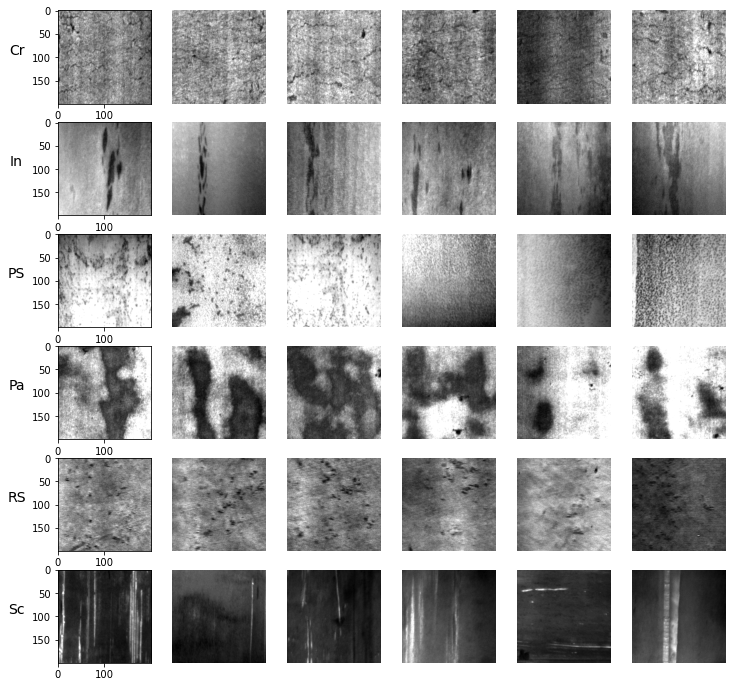

In [47]:
# Get only the unique defects
unique_defects = sorted(df.defect_type.unique())

# Randomly sample images
n_examples = 6
samples = []
for ud in unique_defects:
    samples.append(list(df.loc[df.defect_type==ud].image_path.sample(n_examples).values))
samples = [im_path for samp_group in samples for im_path in samp_group] # flatten the list
    
# Set up figure
figx, figy = (n_examples*2, len(unique_defects)*2)
fig, axes = plt.subplots(ncols=n_examples, 
                         nrows=len(unique_defects), 
                         figsize=(figx, figy))

# Plot images
axes = axes.ravel()
for ax, s in zip(axes, samples):
    img = imread(s)
    ax.imshow(img, cmap='gray')

# Get indices of each image that starts a row
rows = np.arange(0, n_examples*len(unique_defects), n_examples)

# Set y label for each row
for idx, r in enumerate(rows):
    axes[r].set_ylabel(f"{unique_defects[idx]}", rotation=0, fontsize=14, labelpad=15)

# Hide axes for all images except the ones on the left
for ix in np.delete(np.arange(0,n_examples*len(unique_defects)), rows):
    axes[ix].axis('off')
    
# Let's save our figure in the results directory

fig.savefig(RESULTS_DIR.joinpath("1_dataset_visualization.png"), bbox_inches='tight')

We can see some variation in the images for each class. Some images are darker, some brighter, and some might even look more like another defect class! That's okay! In reality, there might even be multiple defects present in an image. We'll build on these concepts in the future to make more robust image analysis systems. For now, let's move on with our simple task.

---
## Prepare the data
In this tutorial, we will use the pre-trained VGG16 convolutional neural network (CNN) to generate a feature vector for each of the images in this dataset. VGG16 was (pre) trained on the ImageNet database for performing a classification task on a variety of natural images. Specifically, VGG16 in its full form will perform a classification of an image into one of 1000 distinct classes like lions and tigers and bears (oh my!). In our context, we don't really care about the classification, so we'll remove classifier layer from VGG16 such that the output is a feature vector. In essense, `IMAGE --> VGG16 --> FEATURE VECTOR`. We'll then use the feature vector to do a variety of other tasks. This is called **transfer learning**; we're taking  a model architecture that was trained (optimized) for a task in one domain (airplanes, boats, etc.), and *transferring* those weights to another domain (steel surface defects). 

### The fully connected layer
For the sake of this tutorial, the feature vector that we'll extract is the first fully connected layer (*fc1*). This feature vector represents an agglomerate of infermation learned from all of the prior convolution layers, and it is a highly convenient feature to use. There are, of course, other features that we might extract from this network. Other features might include the *second* fully connected layer, the output from any of the convolution layers, or a hypercolumn (a feature vector that provides pixel-wise feature vector across a set of filters).

The *fc1* feature vector has 4,096 components. Overkill? Maybe. There is one important requirement that must be satisfied in order to use the fully connected layer(s) of VGG16: the input images must match the orignal data shape used in ImageNet. That is, each image must be of size (224 x 224 x 3) in RGB color space. The images in our dataset are (200 x 200) in grayscale. So, we'll need to convert our images to (224 x 224) and then convert to RGB. Furthermore, we'll need to prepare our images as a *tensor* and apply a preprocessing function. In our example, the tensor representation of a single image has shape (1, 224, 224, 3). If we had a batch of images, say batch_size = BS, then our tensor for the batch would be of shape (BS, 224, 224, 3). The preprocessing function that we'll use is specific to VGG16. The preprocessing function we'll use today subtracts the mean values over the ImageNet dataset from each channel. I've included a handy wrapper that handles all of the necessary preprocessing inside the file `preprocessing.py`; the function is called `process_image`.

In [50]:
# Let's look at an example of a preprocessed input
x, y = df.iloc[0]
input_size = 224
image = imread(x)
tensor = process_image(image, input_size=input_size)
print(tensor.shape)

(1, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


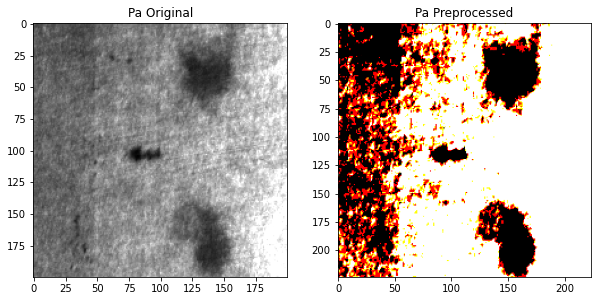

In [51]:
# Show the preprocessed tensor
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10,5))
ax0.imshow(image, cmap='gray')
ax0.set_title(f"{y} Original")
ax1.imshow(tensor[0])
ax1.set_title(f"{y} Preprocessed");

# let's save the figure
fig.savefig(RESULTS_DIR.joinpath("2_original_vs_preprocessed.png"), bbox_inches='tight')

This obviously changes the visual appearance of the image, but we can see that there are still strong signals at the interesting locations.

Now let's go ahead and prepare an entire stack of image tensors. We can't always get away with loading everything into memory, but this happens to be a small enough dataset that we're okay to do this.

In [52]:
# Our tensor stack will be called `x_stack`
x_stack = np.zeros((len(df.image_path), input_size, input_size, 3))
for idx, image_path in enumerate(df.image_path):
    image = imread(image_path)
    tensor = process_image(image, input_size=input_size)
    x_stack[idx] = tensor

In [53]:
x_stack.shape

(1800, 224, 224, 3)

---
## Prepare the CNN
Now we'll load the VGG16 CNN. The Keras API makes this easy to do. Keras was integrated into the TensorFlow API, so we'll go ahead and use the modern approach for loading VGG16.

In [55]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model

In [56]:
# instantiate VGG16 CNN with Keras
cnn = VGG16(include_top=True, weights='imagenet') # load the network with ImageNet weights
model = Model(
    inputs=cnn.input,
    outputs=cnn.get_layer('fc1').output #fully connected layers 
)

# print out the model summary
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

And now to calculate feature vectors for each of the images!

In [60]:
feature_path = RESULTS_DIR.joinpath(f"fc1_features_seed-{seed}.npy")

# Generate feature descriptors
try:
    fc1 = np.load(feature_path) # if the features were already
except:
    fc1 = model.predict(x_stack, verbose=True)

# Save fully connected features
np.save(feature_path, fc1)

In [61]:
fc1.shape

(1800, 4096)

---

## Now What?
You might have heard about a method called Principal Component Analysis (PCA), and that's what we'll do here. We'll use PCA to reduce the dimensionality of our feature manifold, to a more manageable size. We'll also generate a scree plot to observe the retained variance as a function of principal components. If you're taking a course that is using this notebook, refer to your course notes for a more detailed discussion of PCA.

You might also recall that standardizing your feature space is an important step to consider when building models. We'll explore a tale of two feature sets. The first is the original feature set that we just collected from VGG16. The second is a feature set that has been standardized with the equation below where $z$ is the standardized value of the sample $x$, and $u$ and $s$ are the mean and standard deviation of the samples, respectively. See the `StandardScaler` documentation for more details. In our case, we'll calculate this without the mean ($u = 0$) to preserve any sparsity in our original data. Perhaps this is something you'll want to come back to and tweak to see if it changes anything.

$$ z = \frac{x-u}{s}$$

As always, we'll make use of a handy Python library to perform these tasks. The star of the show is `scikit-learn`!

In [84]:
# Scale the feature space
ss = StandardScaler(with_mean=False)
scaled_feats = ss.fit_transform(fc1)

In [85]:
pca = PCA() # create a PCA model
x_pca = pca.fit_transform(fc1) # perform the PCA (two lines--it's that easy!)

s_pca = PCA()
sx_pca = s_pca.fit_transform(scaled_feats) # do it again with the scaled features

Now let's make a couple of scree plots. We'll plot the cumulative sum of explained variance ratio as a function of the number of principal components retained. We'll do this for both the original feature space, as well as features that are scaled.

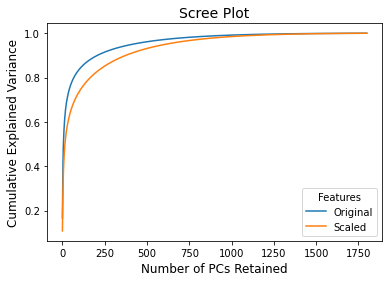

In [112]:
y = np.cumsum(pca.explained_variance_ratio_) # the original feature model
sy = np.cumsum(s_pca.explained_variance_ratio_) # the scaled feature model
x = np.arange(len(y))
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(x,y, label='Original')
ax.plot(x, sy, label='Scaled')
ax.set_ylabel('Cumulative Explained Variance', fontsize=12)
ax.set_xlabel('Number of PCs Retained', fontsize=12)
ax.legend(title='Features')
ax.set_title('Scree Plot', fontsize=14)
fig.savefig(RESULTS_DIR.joinpath('3_pca_scree.pdf'), bbox_inches='tight')

This might be a good point of discussion for the class. What do you think explains this difference? How significant is it? What does this mean?

I'll let you mull this over. Come back to this point and try some explorations into the data to see if any of your hypotheses hold true. For now, let's move on to try and visualize a couple of the principal components. The principal components are ordered by the variance they can each explain as you might gather from the scree plot. So what if we make a scatter plot of the first couple principal components? What might we expect?

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not 1058    Pa
905     Pa
1523    Sc
751     PS
1019    Pa
        ..
1674    Sc
1659    Sc
806     PS
152     Cr
896     PS
Name: defect_type, Length: 1800, dtype: object

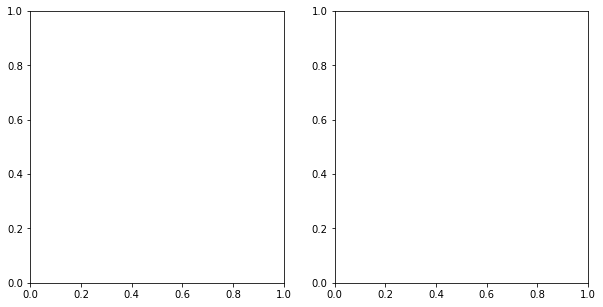

In [113]:
# let's make the scatter plot
# we'll keep doing both the original and scaled variants (why not?)
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10,5))
ax0.scatter(x_pca[:,0],
            x_pca[:,1],
            c=df.defect_type)